# **Transformers for Text Analysis**

In this lab, we will explore Transformer models for text analysis using the [Hugging Face Transformers library](https://huggingface.co/docs/transformers/index). This library provides a wide range of pre-trained models that we can leverage for various natural language processing (NLP) tasks.


First, we need to install and import the necessary libraries.

In [1]:
# Install necessasary packages, if not done before
!pip install transformers evaluate accelerate

## **Downloading Datasets**

Now, we will use two datasets for this lab:

1. **Federal Reserve Speeches (1996–2024)**  
   - This dataset contains **text data** from speeches delivered by Federal Reserve officials over the years.  

2. **[Chicago Fed National Activity Index (CFNAI)](https://fred.stlouisfed.org/series/CFNAI)**  
   - The CFNAI is a comprehensive economic indicator that tracks **85 key economic factors** such as employment, production, and consumption.  
   - It helps measure national economic activity:
     - **Zero value** → Economy is growing at its historical trend rate.
     - **Negative values** → Below-average growth.(Economy contracting)
     - **Positive values** → Above-average growth.(Economy expanding)

In [2]:
!gdown --fuzzy 'https://drive.google.com/file/d/1uVt9BC2tgr-MWrFZvYvA_I8IzTabNZtL/view?usp=sharing'
!gdown --fuzzy 'https://drive.google.com/file/d/1I7isSks6Y8kJoigbDZJumgdQ1fFpwn4i/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1uVt9BC2tgr-MWrFZvYvA_I8IzTabNZtL
To: /content/fed_speeches.csv
100% 49.5M/49.5M [00:00<00:00, 54.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I7isSks6Y8kJoigbDZJumgdQ1fFpwn4i
To: /content/CFNAI.csv
100% 5.76k/5.76k [00:00<00:00, 23.7MB/s]


In [3]:
# Imports
import numpy as np
import os
import pandas as pd
import random
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# Import Pytorch lybraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import _LRScheduler

# Huggingface
import transformers
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import pipeline
from transformers import set_seed
from datasets import load_dataset, Dataset, Value, ClassLabel, Features, load_from_disk
import evaluate

Now, we will load the Federal Reserve Speeches dataset.
Once loaded, we will inspect the structure of the dataset to understand its key columns, such as date, speaker, speech content, and topic. This will help us determine how to preprocess and analyze the text data effectively.

In [4]:
fed_speech = pd.read_csv("/content/fed_speeches.csv", delimiter=",", on_bad_lines="skip", engine="python")

In [5]:
fed_speech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2463 non-null   object
 1   text    2463 non-null   object
dtypes: object(2)
memory usage: 38.6+ KB


In [6]:
fed_speech.head(10)

,date,text
0,1996-12-19 00:00:00,Ms. Rivlin discusses the prudential regulation...
1,1997-04-24 00:00:00,Mr. Meyer discusses the economic outlook and t...
2,1997-12-15 00:00:00,"Mr. Kelley discusses the ""Millennium Bug"" from..."
3,1997-12-02 00:00:00,Mr. Greenspan's remarks to the Economic Club o...
4,1997-11-17 00:00:00,Mr. McDonough gives a US perspective on Econom...
5,1997-11-07 00:00:00,Mr. Greenspan's remarks at the Center for Fina...
6,1997-11-13 00:00:00,Mr. Greenspan's testimony before the House of ...
7,1997-11-04 00:00:00,Remarks by Ms. Phillips at the Asset/Liability...
8,1997-10-30 00:00:00,Ms. Phillips discusses trends and challenges i...
9,1997-11-04 00:00:00,Mr. Kelley's testimony to the US House of Repr...


## Data preprocess - merging

In this step, we will preprocess the Federal Reserve Speeches dataset to prepare it for analysis. First, we will extract the **year** and **month** from the speech dates. Then, we will shift the month forward by one to align each speech with the economic conditions of the following month.

Our goal is to predict the next month's economic upturn or downturn based on the language used in Federal Reserve speeches. This adjustment ensures that our model learns from past speeches to forecast future economic trends more effectively.

In [7]:
# Create year and month columns
fed_speech['date'] = pd.to_datetime(fed_speech['date'], errors='coerce')
fed_speech["year"] = fed_speech["date"].dt.year  # Extract year
fed_speech["month"] = fed_speech["date"].dt.month  # Extract month

# Shift df1's month forward by 1
fed_speech["month"] += 1

# Handle December (12 → 1 and increase year)
fed_speech.loc[fed_speech["month"] == 13, "month"] = 1
fed_speech.loc[fed_speech["month"] == 1, "year"] += 1

Next, we will load the Chicago Fed National Activity Index (CFNAI) dataset, which serves as a key indicator of U.S. economic activity.

Once loaded, we will merge the CFNAI dataset with the Federal Reserve Speeches dataset using year and month as the merging keys. Since we previously adjusted the speech dataset by shifting the month forward, this ensures that each speech is aligned with the economic activity of the following month.

In [8]:
econ_index = pd.read_csv('/content/CFNAI.csv')
econ_index.columns = ['date', 'CFNAI']
econ_index['date'] = pd.to_datetime(econ_index['date'], errors='coerce')
econ_index["year"] = econ_index["date"].dt.year  # Extract year
econ_index["month"] = econ_index["date"].dt.month  # Extract month
econ_index.drop(columns=['date'], inplace=True)
econ_index

,CFNAI,year,month
0,-0.86,1996,1
1,0.72,1996,2
2,-0.15,1996,3
3,0.41,1996,4
4,0.39,1996,5
...,...,...,...
343,-0.04,2024,8
344,-0.23,2024,9
345,-0.54,2024,10
346,-0.01,2024,11


In [9]:
merged_df = fed_speech.merge(econ_index, on=["year", "month"], how="left")
merged_df

,date,text,year,month,CFNAI
0,1996-12-19,Ms. Rivlin discusses the prudential regulation...,1997,1,0.27
1,1997-04-24,Mr. Meyer discusses the economic outlook and t...,1997,5,0.19
2,1997-12-15,"Mr. Kelley discusses the ""Millennium Bug"" from...",1998,1,0.30
3,1997-12-02,Mr. Greenspan's remarks to the Economic Club o...,1998,1,0.30
4,1997-11-17,Mr. McDonough gives a US perspective on Econom...,1997,12,0.04
...,...,...,...,...,...
2458,2024-11-14,Jerome H Powell: Economic outlook\nSpeech by M...,2024,12,0.15
2459,2024-11-20,Michelle W Bowman: Approaching policymaking pr...,2024,12,0.15
2460,2024-11-14,For release on delivery\n7:00 a.m. EST (9:00 a...,2024,12,0.15
2461,2024-12-03,Adriana D Kugler: A year in review - a tale of...,2025,1,NaN


## **Text Preprocessing: Tokenization, Stopword Removal, and Cleaning**

In this step, we preprocess the speech text by **tokenizing, removing stopwords, and eliminating punctuation** to prepare the data for further analysis.

### **1. Import Required Libraries**
The following libraries from **NLTK (Natural Language Toolkit)** are used:
- `word_tokenize` → Splits text into individual words (tokens).
- `stopwords` → Provides a list of common English stopwords (e.g., "the", "is", "and").
- `string` → Used to remove punctuation.

In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))


def clean_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize text
    table = str.maketrans('', '', string.punctuation)  # Create a table for removing punctuation
    filtered_tokens = [
        token.translate(table) for token in tokens
        if token.isalnum() and token not in stop_words  # Remove stop words here!
    ]
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

merged_df['text_cleaned'] = merged_df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


As we discuss in the book, you would need to test the best performance depending on the cleaning steps necessary. Normally, either doing nothing, removing stopwords, or lowercase would lead to the best performance depending on the application area. Combining strategies may lead to decreased performance. Test different strategies and see if you can improve this model!

You can inspect how the **`clean_text`** function processed the text by viewing the cleaned version stored in the **`text_cleaned`** column.

In [11]:
merged_df.tail(5)

,date,text,year,month,CFNAI,text_cleaned
2458,2024-11-14,Jerome H Powell: Economic outlook\nSpeech by M...,2024,12,0.15,jerome h powell economic outlook speech mr jer...
2459,2024-11-20,Michelle W Bowman: Approaching policymaking pr...,2024,12,0.15,michelle w bowman approaching policymaking pra...
2460,2024-11-14,For release on delivery\n7:00 a.m. EST (9:00 a...,2024,12,0.15,release delivery est local time november 14 20...
2461,2024-12-03,Adriana D Kugler: A year in review - a tale of...,2025,1,NaN,adriana kugler year review tale two supply sho...
2462,2024-12-02,Christopher J Waller: Cut or skip?\nSpeech by ...,2025,1,NaN,christopher j waller cut skip speech mr christ...


As observed above, rows corresponding to **January 2025 (2025-01)** do not have CFNAI values. To address this, we will extract these rows and set them aside for testing.


In [12]:
# Extract the last two rows that contain NaN values
nan_rows_df = merged_df[merged_df.isna().any(axis=1)]

# Remove these rows from the main DataFrame
merged_df = merged_df.drop(nan_rows_df.index)

## **Visualizing Frequent Words in FED Speeches with a Word Cloud**  

In this step, we generate a **word cloud** to visualize the most frequently used words in the **Federal Reserve speeches dataset**. A word cloud is a useful tool for quickly identifying common terms in text data.


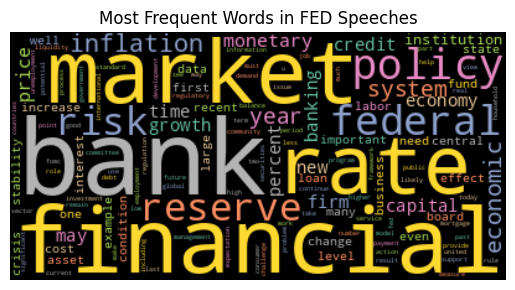

In [13]:
from wordcloud import WordCloud

sample_txt = " ".join(i for i in merged_df['text_cleaned'])

wc = WordCloud(colormap="Set2",collocations=False).generate(sample_txt)
plt.title("Most Frequent Words in FED Speeches")
plt.axis("off")
plt.imshow(wc,interpolation='bilinear')
plt.show()

Pretty cool! We can see that the Federal Reserve frequently uses words like risk, inflation, and financial, among others.

## Labelling

In this step, we categorize the **Chicago Fed National Activity Index (CFNAI)** values into binary labels to prepare our dataset for classification.

---

### **1. Define Bins and Labels**  
We create two categories based on the CFNAI values:  
- **Negative or zero CFNAI (`≤ 0`) → Label 1**  
- **Positive CFNAI (`> 0`) → Label 0**  


In [14]:
# Define bins and labels
bins = [-float('inf'), 0, float('inf')]
labels = [1, 0]

# Apply categorization
merged_df["label"] = pd.cut(
    merged_df["CFNAI"], bins=bins, labels=labels, include_lowest=True
)

# Convert to integer type
merged_df["label"] = merged_df["label"].astype(int)

merged_df

,date,text,year,month,CFNAI,text_cleaned,label
0,1996-12-19,Ms. Rivlin discusses the prudential regulation...,1997,1,0.27,rivlin discusses prudential regulation banks i...,0
1,1997-04-24,Mr. Meyer discusses the economic outlook and t...,1997,5,0.19,meyer discusses economic outlook challenges fa...,0
2,1997-12-15,"Mr. Kelley discusses the ""Millennium Bug"" from...",1998,1,0.30,kelley discusses millennium bug public sector ...,0
3,1997-12-02,Mr. Greenspan's remarks to the Economic Club o...,1998,1,0.30,greenspan remarks economic club new york remar...,0
4,1997-11-17,Mr. McDonough gives a US perspective on Econom...,1997,12,0.04,mcdonough gives us perspective economic moneta...,0
...,...,...,...,...,...,...,...
2456,2024-11-15,John C Williams: 100 years at 33 Liberty Stree...,2024,12,0.15,john c williams 100 years 33 liberty street re...,0
2457,2024-11-20,For release on delivery\n11:00 a.m. EST\nNovem...,2024,12,0.15,release delivery est november 20 2024 economic...,0
2458,2024-11-14,Jerome H Powell: Economic outlook\nSpeech by M...,2024,12,0.15,jerome h powell economic outlook speech mr jer...,0
2459,2024-11-20,Michelle W Bowman: Approaching policymaking pr...,2024,12,0.15,michelle w bowman approaching policymaking pra...,0


We can see that the labels are fairly balanced.

In [15]:
merged_df.label.value_counts()

,count
label,
1,1249
0,1211


Now that we have cleaned and processed the dataset, we will save it for future use.


In [16]:
# Save to CSV
merged_df.to_csv('FEDSpeechesProcessed.csv', index=False)

## **Preparing the Dataset for Model Training**  

In this step, we **convert the preprocessed dataset into a Hugging Face `Dataset` format**, encode the labels, and split the data into training and testing sets.

---

We extract the **cleaned text (`text_cleaned`)** and its corresponding **label (`label`)** from `merged_df`, then convert it into a Hugging Face `Dataset`.


In [17]:
# Create the dataset
fed_speech_data = Dataset.from_pandas(merged_df.loc[:,['text_cleaned', 'label']])

# Set the label variable
fed_speech_data = fed_speech_data.class_encode_column("label")

# Drop the index variable
fed_speech_data = fed_speech_data.remove_columns(["__index_level_0__"])

# Train / test split
fed_speech_data = fed_speech_data.train_test_split(0.33)
fed_speech_data

Stringifying the column:   0%|          | 0/2460 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2460 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_cleaned', 'label'],
        num_rows: 1648
    })
    test: Dataset({
        features: ['text_cleaned', 'label'],
        num_rows: 812
    })
})

In [18]:
fed_speech_data['train'].features

{'text_cleaned': Value(dtype='string', id=None),
 'label': ClassLabel(names=['0', '1'], id=None)}

## **Tokenizing the Text Data**  

Before feeding our text data into a Transformer model, we need to **tokenize** it. Tokenization converts raw text into numerical format that the model can understand.

---

We use the **DistilBERT tokenizer** from Hugging Face’s `transformers` library.


In [41]:
# Tokenize the data.
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",  do_lower_case=False, processing_class=True)

In [42]:
# Function to truncate text. Our text is very long!
def preprocess_function(examples):
    return tokenizer(examples["text_cleaned"], truncation=True)

In [43]:
tokenized_fed_speech_data = fed_speech_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/1648 [00:00<?, ? examples/s]

Map:   0%|          | 0/812 [00:00<?, ? examples/s]

In [44]:
# Save the outcome to disk to not run this again.
tokenized_fed_speech_data.save_to_disk("TokenizedData")

Saving the dataset (0/1 shards):   0%|          | 0/1648 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/812 [00:00<?, ? examples/s]

## **Applying Data Collation for Efficient Batching**  

When working with Transformer models, input sequences need to be **padded** to the same length within a batch. To handle this efficiently, we use a **data collator**.

---


In [23]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
# How many classes there are.
num_labels = len(merged_df["label"].unique())
print(f'There are {num_labels} classes in the dataset.')

There are 2 classes in the dataset.


Now that we have tokenized the text data, we need to define the **Transformer model** that will be used for classification.



In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=num_labels
    )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We define the **evaluation metric** to assess the performance of our model. We use **accuracy**, which measures the proportion of correctly classified samples.


In [26]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## **Defining Training Parameters**  

Now, we configure the **training arguments** that determine how our model will be trained using the Hugging Face `Trainer` API.

---

In [27]:
training_args = TrainingArguments(
    # Where to store the model.
  output_dir="ModelOutput",
    # Learning rate to use.
    learning_rate=1e-4,
    # Batch size to use per GPU in training.
    #per_device_train_batch_size=32,  ## T4
    per_device_train_batch_size=200,  ## T4
    # Batch size to use per GPU in evaluation
    #per_device_eval_batch_size=32,   ## T4
    per_device_eval_batch_size=200,  ## T4
    # Epochs to train
    num_train_epochs=15,
    # If decaying or not the weights
    weight_decay=5e-3,
    # When to evaluate the model
    eval_strategy="epoch",
    # When to save checkpoint
    save_strategy="epoch",
    # Load best after training? No as we don't have validation / test difference.
    load_best_model_at_end=False,
    # Save in Huggingface? (Account required)
    push_to_hub=False,
    # How often to log training
    logging_steps=100,
)

We **set a fixed random seed** for reproducibility and initialize the Hugging Face `Trainer` for model training.

In [28]:
import gc
gc.collect()
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

In [29]:
# Set a fixed seed value
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
transformers.set_seed(SEED)

# Empty VRAM
torch.cuda.empty_cache()

# Create trainer object.
trainer = Trainer(
    # What model to use.
    model=model,
    # Arguments to the model
    args=training_args,
    # Training data
    train_dataset=tokenized_fed_speech_data["train"],
    # Test dataset
    eval_dataset=tokenized_fed_speech_data["test"],
    # How to pad sequences
    data_collator=data_collator,
    # Error function
    compute_metrics=compute_metrics,
)

Now that we have set up the **dataset, tokenizer, model, training arguments, and `Trainer`**, it's time to **train the model**!  

To enable experiment tracking, we will use **Weights & Biases (W&B)** for logging training metrics. Before training, you need to sign in to [wandb.ai](https://wandb.ai/home) to get an API key.



In [30]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: cbravoro (thebal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.701673,0.477833
2,No log,0.691514,0.522167
3,No log,0.687233,0.578818
4,No log,0.666405,0.628079
5,No log,0.588089,0.700739
6,No log,0.635960,0.683498
7,No log,0.777497,0.635468
8,No log,0.652983,0.667488
9,No log,0.739282,0.662562
10,No log,0.756704,0.687192


TrainOutput(global_step=180, training_loss=0.3068454239103529, metrics={'train_runtime': 381.0646, 'train_samples_per_second': 86.495, 'train_steps_per_second': 0.472, 'total_flos': 4366125459701760.0, 'train_loss': 0.3068454239103529, 'epoch': 20.0})

We can see that the **accuracy is increasing** as training progresses, indicating that the model is learning from the data.  


After training, we need to **save the model** so we can reuse it for evaluation, inference, or further fine-tuning without retraining from scratch.



In [31]:
# Save the model to a folder
trainer.save_model('FEDSppechModel')

In [32]:
# Zip it
!zip -r DistilBert.zip FEDSppechModel

  adding: FEDSppechModel/ (stored 0%)
  adding: FEDSppechModel/training_args.bin (deflated 51%)
  adding: FEDSppechModel/model.safetensors (deflated 8%)
  adding: FEDSppechModel/config.json (deflated 45%)
  adding: FEDSppechModel/special_tokens_map.json (deflated 42%)
  adding: FEDSppechModel/vocab.txt (deflated 53%)
  adding: FEDSppechModel/tokenizer.json (deflated 71%)
  adding: FEDSppechModel/tokenizer_config.json (deflated 75%)


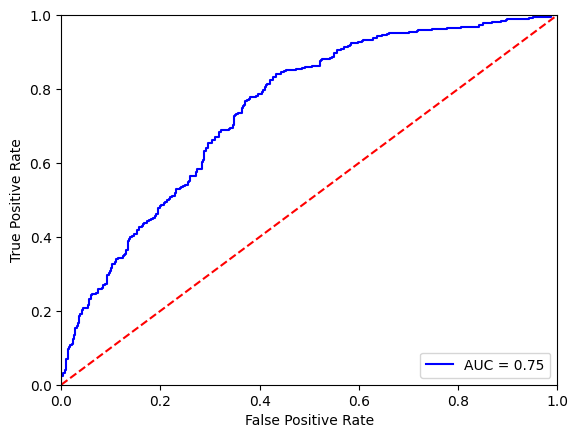

In [47]:
# Calculate AUC over the test set.
predictions = trainer.predict(tokenized_fed_speech_data["test"])
preds = predictions.predictions
preds

# Plot ROC Curve
fpr, tpr, threshold = roc_curve(tokenized_fed_speech_data["test"]["label"], preds[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('c3_ROC_Curve.pdf')
plt.show()


## **Testing the Model on Recent FED Speeches**  

Now that we have trained our model, let's test it on **recent Federal Reserve speeches** to evaluate its performance in predicting economic sentiment.

---


In [33]:
text = nan_rows_df.iloc[0]['text_cleaned']
text

'release delivery est january 8 2024 new year resolutions bank regulatory policymakers remarks michelle bowman member board governors federal reserve system south carolina bankers association 2024 community bankers conference columbia south carolina january 8 2024 pleasure join afternoon south carolina community bankers conference always welcome opportunity learn share perspective bankers issues affecting economy financial industry today focus discussion monetary policy bank regulatory reforms evolving standards bank supervision new developments payments system look forward learning insights perspectives issues particularly views bank supervision regulatory reforms thoughts direction economy kick new year also good time look back 2023 consider new year resolutions coming year discussing bank regulation supervision like offer thoughts economy monetary policy federal open market committee fomc meeting december left target range federal funds rate percent continued fed securities holdings

In [34]:
# Apply tokenizer and return pytorch tensors
inputs = tokenizer(text, return_tensors="pt", truncation=True)

In [35]:
with torch.no_grad():
    outputs = model(**inputs.to("cuda"))
    logits = outputs.logits

In [36]:
# Probabilities
probs = nn.functional.softmax(logits, dim=1).cpu().numpy()
print(probs)

# Class
print(f'The text is predicted to be of class {np.argmax(probs)}')

[[0.37557513 0.6244248 ]]
The text is predicted to be of class 1


Our model predicts an economic downturn in January 2025 based on Federal Reserve speeches from December 2024.

And the CFNAI for January 2025 is [-0.03](https://fred.stlouisfed.org/series/CFNAI), which is classified as econnomic downturn in our analysis!


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
# Move the best model to drive
!cp DistilBert.zip '/content/drive/MyDrive/Colab Notebooks/DL in Banking Book/DeepLearningInBankingBook/TextBook_Lab'